In [1]:
import pandas as pd
import numpy as np
import json
import datetime as dt

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import folium

mpl.rcParams.update({'axes.titlesize' : 24, 'axes.labelsize' : 18, 'xtick.labelsize' : 14, 'ytick.labelsize' : 14})

In [2]:
# Import the data and do some basic cleaning
df = pd.read_csv('EMS_Incident_Dispatch_Data.csv')

def limit_dates(df, start_date, end_date):
    ''' 
    Set INCIDENT_DATETIME to a datetime format and slice to include only relevant dates.
    Creates a new 'INCIDENT_DATE' column to allow for grouping
    '''
    
    # Format to DT
    df['INCIDENT_CLOSE_DATETIME'] = pd.to_datetime(df['INCIDENT_CLOSE_DATETIME'], format='%m/%d/%Y %I:%M:%S %p')
    
    # Create and apply mask
    mask = (df['INCIDENT_CLOSE_DATETIME'] > start_date) & (df['INCIDENT_CLOSE_DATETIME'] <= end_date)
    df = df.loc[mask]
    
    # New column for date only
    df['INCIDENT_DATE'] = df['INCIDENT_CLOSE_DATETIME'].dt.date
    
    # Drop columns where there is a negative value for time calculations        
    df = df.loc[(df['DISPATCH_RESPONSE_SECONDS_QY'] >= 0) & \
            (df['INCIDENT_RESPONSE_SECONDS_QY'] >= 0) & \
            (df['INCIDENT_TRAVEL_TM_SECONDS_QY'] >= 0)]
    
    # Remove a random zip code from Brooklyn that shows up in the data
    df = df.loc[df['ZIPCODE'] != 11229]
    
    return df

df = limit_dates(df, '01/01/2020', '06/01/2020')
df_covid = limit_dates(df, '3/1/2020', '4/30/2020')

C:\Users\Jeffrey\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,11,17,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-2-1ac764e06e1b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INCIDENT_DATE'] = df['INCIDENT_CLOSE_DATETIME'].dt.date
<ipython-input-2-1ac764e06e1b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INCIDENT_DATE'] = d

# Plot Severity Over Time

These plots show how the level of severity has changed over time. The first plot details the average value, while the second and third split the data into each level of severity and show how each level has changed over time.

You can clearly see that there is a massive drop in level and a return to normal over time.

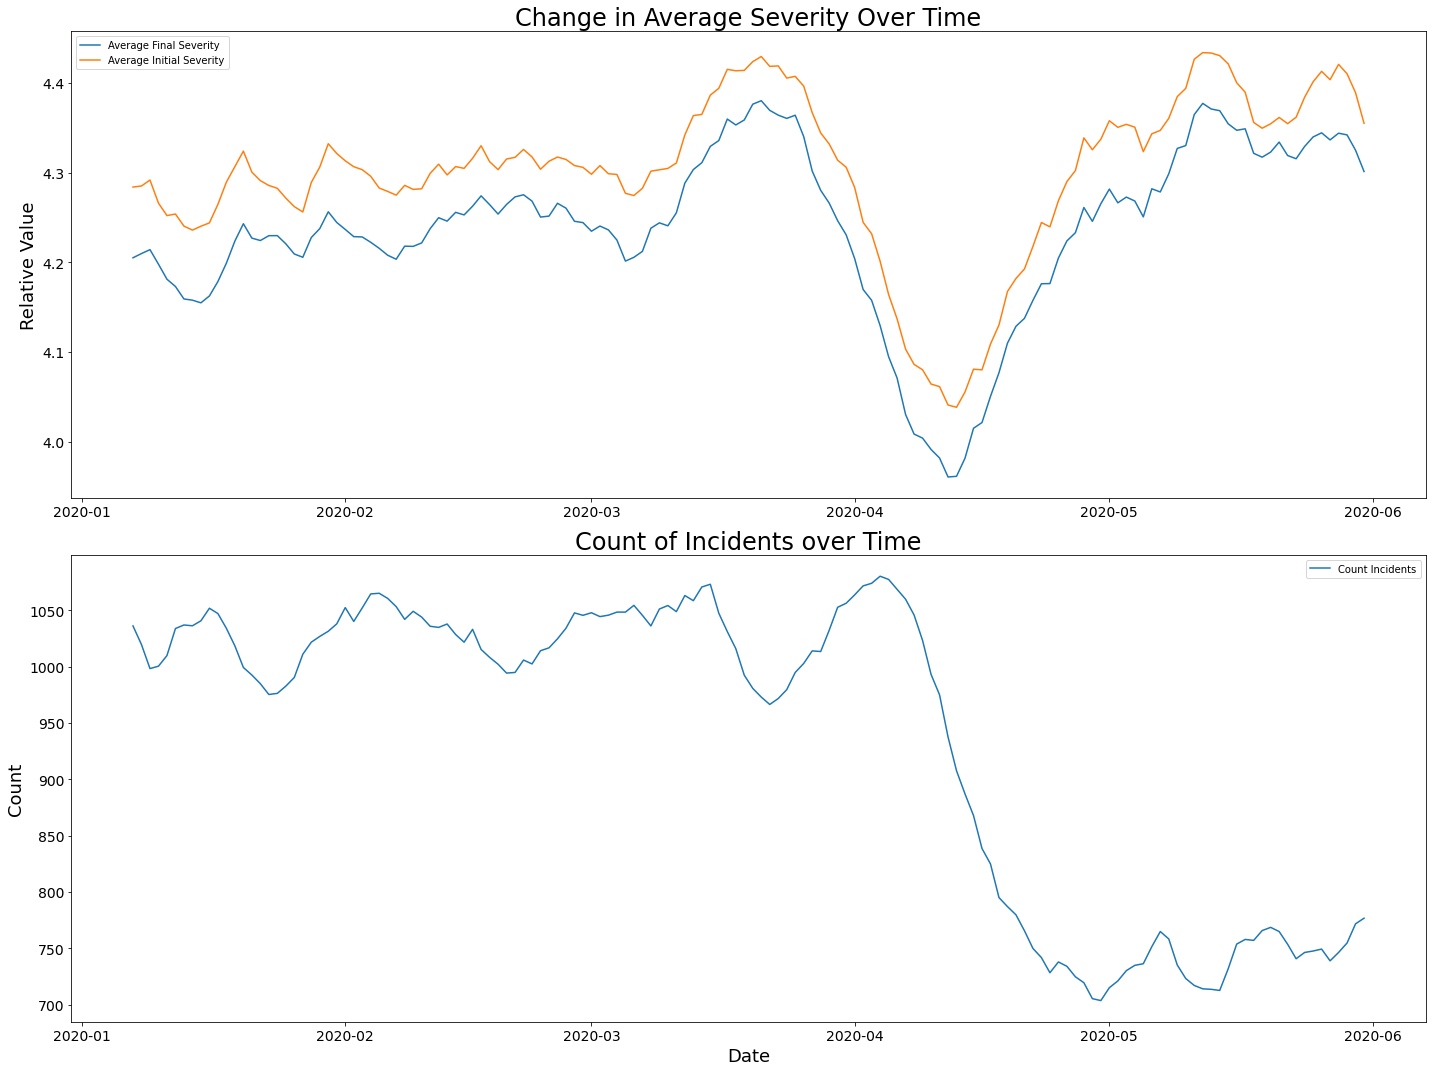

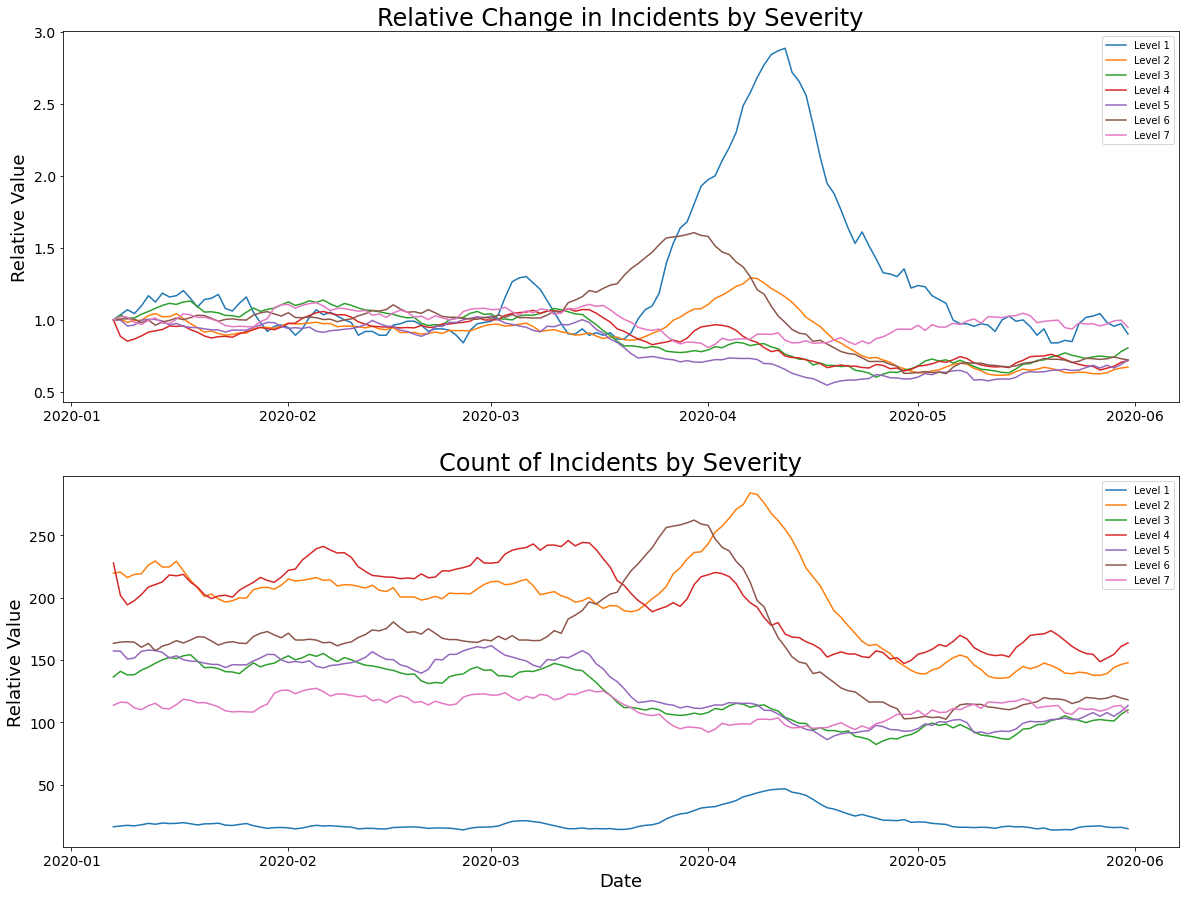

In [3]:
plt.figure(figsize=(20,15))
plt.subplot(2, 1, 1)

# Plot the average rate
for i in ['FINAL_SEVERITY_LEVEL_CODE', 'INITIAL_SEVERITY_LEVEL_CODE']:
    x = df[['INCIDENT_DATE', i]].groupby('INCIDENT_DATE').mean()
    x = x.rolling(7).mean() # Weekly average to account for variability
    plt.plot(x)
    
plt.legend(['Average Final Severity', 'Average Initial Severity'])
plt.title('Change in Average Severity Over Time')
plt.ylabel('Relative Value')
#plt.xlabel('Date')

# Plot the over time rate
plt.subplot(2, 1, 2)
for i in ['FINAL_SEVERITY_LEVEL_CODE']:
    x = df[['INCIDENT_DATE', i]].groupby('INCIDENT_DATE').count()
    x = x.rolling(7).mean()
    plt.plot(x)
    
plt.legend(['Count Incidents'])
plt.title('Count of Incidents over Time')
plt.ylabel('Count')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Plot the relative change by each severity
plt.figure(figsize=(20,15))
plt.subplot(2, 1, 1)
for i in range(min(df['FINAL_SEVERITY_LEVEL_CODE']), max(df['FINAL_SEVERITY_LEVEL_CODE'])):
    temp_df = df.loc[df['FINAL_SEVERITY_LEVEL_CODE'] == i]
    x = temp_df[['INCIDENT_DATE', 'FINAL_SEVERITY_LEVEL_CODE']].groupby('INCIDENT_DATE').count()
    x = x.rolling(7).mean()
    x = x.dropna()
    x = x / x['FINAL_SEVERITY_LEVEL_CODE'][0]
    plt.plot(x)
legend_values  = ['Level '+str(x) for x in list(range(min(df['FINAL_SEVERITY_LEVEL_CODE']), max(df['FINAL_SEVERITY_LEVEL_CODE'])))]
plt.legend(legend_values)
plt.title('Relative Change in Incidents by Severity')
plt.ylabel('Relative Value')
#plt.xlabel('Date')

# Plot the count by each severity
plt.subplot(2, 1, 2)
for i in range(min(df['FINAL_SEVERITY_LEVEL_CODE']), max(df['FINAL_SEVERITY_LEVEL_CODE'])):
    temp_df = df.loc[df['FINAL_SEVERITY_LEVEL_CODE'] == i]
    x = temp_df[['INCIDENT_DATE', 'FINAL_SEVERITY_LEVEL_CODE']].groupby('INCIDENT_DATE').count()
    x = x.rolling(7).mean()
    x = x.dropna()
    plt.plot(x)
legend_values  = ['Level '+str(x) for x in list(range(min(df['FINAL_SEVERITY_LEVEL_CODE']), max(df['FINAL_SEVERITY_LEVEL_CODE'])))]
plt.legend(legend_values)
plt.title('Count of Incidents by Severity')
plt.ylabel('Relative Value')
plt.xlabel('Date')
plt.show()

What is the relationship between the point in time recorded during the ambulance trip and the final outcome of the accident?

In [4]:
# Create a slice of the data
subset = df[['INCIDENT_DATE', 'DISPATCH_RESPONSE_SECONDS_QY', 'INCIDENT_RESPONSE_SECONDS_QY', 
             'INCIDENT_TRAVEL_TM_SECONDS_QY', 'HELD_INDICATOR']]
subset.columns = ['Date', 'Call to Dispatch Time', 'Call to Arrival Time', 'Dispatch to Arrival Time', 'Delay']

# Convert delay to a 0/1 column to work with groupby mean
y_n = {'Delay': {'Y': 1, 'N': 0}}
subset = subset.replace(y_n)
subset = subset.dropna().reset_index(drop = True)

# Groupby mean for each value
grouped_subset = subset.groupby('Date').mean()

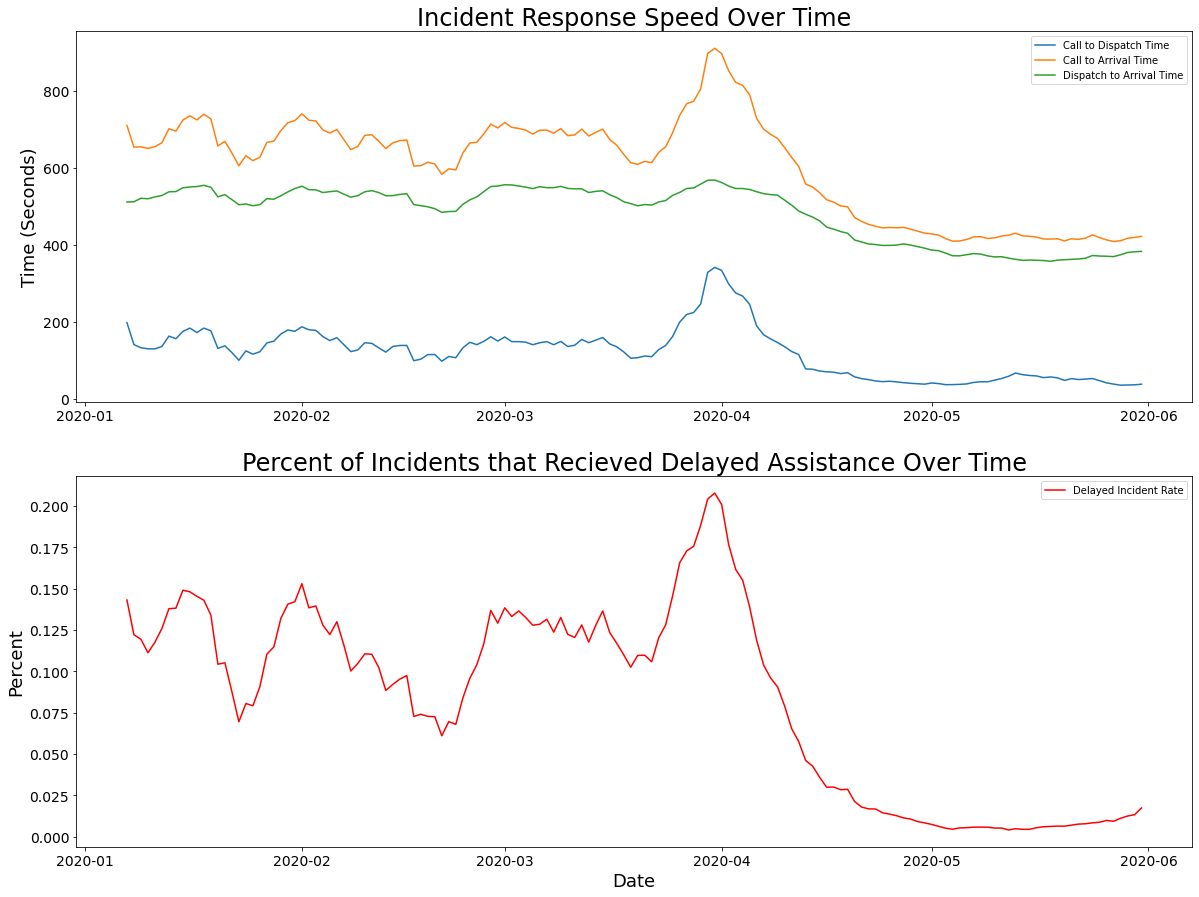

In [5]:
# Plot the relative change by each severity
plt.figure(figsize=(20, 15))

# Dispatch Times
plt.subplot(2, 1, 1)
for _ in ['Call to Dispatch Time', 'Call to Arrival Time', 'Dispatch to Arrival Time']:
    plt.plot(grouped_subset[_].rolling(7).mean())
legend_values  = ['Call to Dispatch Time', 'Call to Arrival Time', 'Dispatch to Arrival Time']
plt.legend(legend_values)
plt.title('Incident Response Speed Over Time')
plt.ylabel('Time (Seconds)')
#plt.xlabel('Date')

# Delay Rate
plt.subplot(2, 1, 2)
plt.plot(grouped_subset['Delay'].rolling(7).mean(), color='red')
legend_values  = ['Delayed Incident Rate']
plt.legend(legend_values)
plt.title('Percent of Incidents that Recieved Delayed Assistance Over Time')
plt.ylabel('Percent')
plt.xlabel('Date')

plt.show()

How does time correlate with outcomes?

In [6]:
# Create a slice of the data
subset = df_covid[['INCIDENT_DATE', 'DISPATCH_RESPONSE_SECONDS_QY', 'INCIDENT_RESPONSE_SECONDS_QY', 
             'INCIDENT_TRAVEL_TM_SECONDS_QY', 'INCIDENT_DISPOSITION_CODE', 'ZIPCODE']].copy()
subset.columns = ['Date', 'Call to Dispatch Time', 'Call to Arrival Time', 'Dispatch to Arrival Time', 'Result', 'ZIPCODE']

# Add death column
subset['Death'] = np.where(subset['Result'] == 83, 1, 0)
subset['Gone'] = np.where(subset['Result'] == 96, 1, 0)
subset['Transported'] = np.where(subset['Result'] == 82, 1, 0)
subset['Corrected'] = np.where(subset['Result'] == 91, 1, 0)

subset = subset.dropna().reset_index(drop = True)
subset

,Date,Call to Dispatch Time,Call to Arrival Time,Dispatch to Arrival Time,Result,ZIPCODE,Death,Gone,Transported,Corrected
0,2020-03-01,8,368.0,360.0,82.0,10013.0,0,0,1,0
1,2020-03-01,18,553.0,535.0,82.0,10011.0,0,0,1,0
2,2020-03-01,29,738.0,709.0,82.0,10065.0,0,0,1,0
3,2020-03-01,20,550.0,530.0,82.0,10001.0,0,0,1,0
4,2020-03-01,157,1234.0,1077.0,82.0,10026.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
56270,2020-04-29,14,502.0,488.0,82.0,10031.0,0,0,1,0
56271,2020-04-29,9,225.0,216.0,93.0,10034.0,0,0,0,0
56272,2020-04-29,17,267.0,250.0,93.0,10012.0,0,0,0,0
56273,2020-04-29,9,328.0,319.0,93.0,10026.0,0,0,0,0


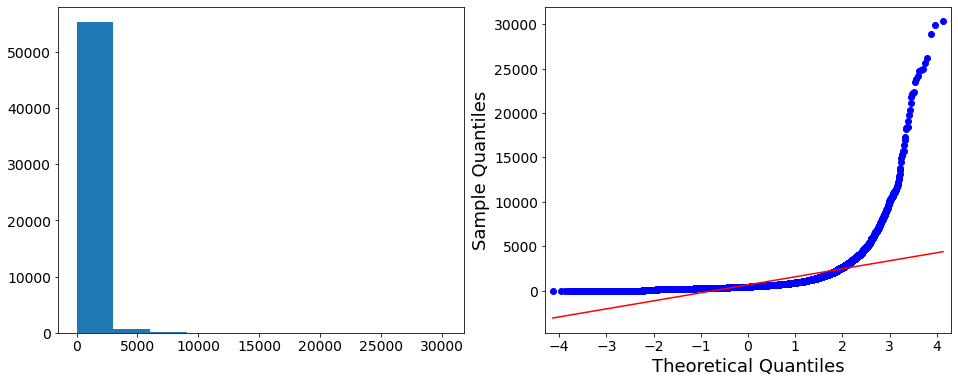

Shapiro-Wilk Test for Normality:
Statistics=0.309, p=0.000
Sample of 1000 does not look Gaussian (reject H0)


In [7]:
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot

sample = subset.sample(n = 1000)
          
# Visual Inspection
fig, (ax, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16,6)
ax.hist(subset['Call to Arrival Time'])
qqplot(subset['Call to Arrival Time'], line='s', ax = ax2)
plt.show()

# Shapiro-Wilk Test
stat, p = shapiro(sample['Call to Arrival Time'])
print('Shapiro-Wilk Test for Normality:')
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Print output
alpha = 0.05
if p > alpha:
    print('Sample of 1000 looks Gaussian (fail to reject H0)')
else:
    print('Sample of 1000 does not look Gaussian (reject H0)')

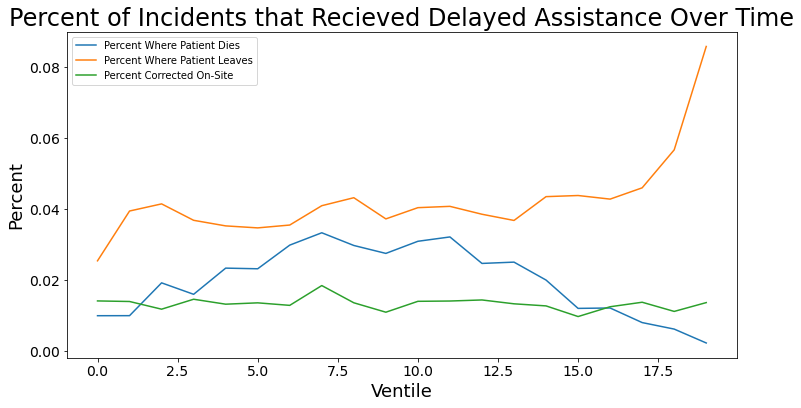

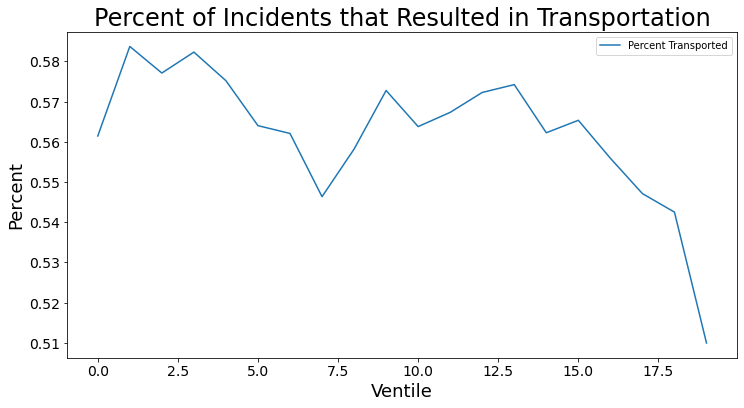

In [8]:
plt.figure(figsize=(12, 6))
subset['Quantile'] = pd.qcut(subset['Call to Dispatch Time'], 20, retbins=True)[0]
plt.plot(subset.groupby('Quantile').mean()[['Death', 'Gone', 'Corrected']].reset_index(drop=True))
legend_values  = ['Percent Where Patient Dies', 'Percent Where Patient Leaves', 'Percent Corrected On-Site']
plt.legend(legend_values)
plt.title('Percent of Incidents that Recieved Delayed Assistance Over Time')
plt.ylabel('Percent')
plt.xlabel('Ventile')

plt.show()

plt.figure(figsize=(12, 6))
subset['Quantile'] = pd.qcut(subset['Call to Dispatch Time'], 20, retbins=True)[0]
plt.plot(subset.groupby('Quantile').mean()[['Transported']].reset_index(drop=True))
legend_values  = ['Percent Transported']
plt.legend(legend_values)
plt.title('Percent of Incidents that Resulted in Transportation')
plt.ylabel('Percent')
plt.xlabel('Ventile')

plt.show()

What is the relationship between the dispatch area and the arrival location?

Visualize the geographic areas, and the average number of daily EMS dispatches in NYC

In [9]:
# Get a subset of the data (from the subset)
zip_data = subset[['Call to Arrival Time', 'Death', 'ZIPCODE']].dropna()
zip_data['ZIPCODE'] = zip_data['ZIPCODE'].astype(str)
zip_data['ZIPCODE'] = [x[:-2] for x in zip_data['ZIPCODE']]
zip_data = zip_data.groupby('ZIPCODE').mean().reset_index()

# Load JSON and remove excess zips
with open('nyc_zips.json', 'r') as jsonFile:
    data = json.load(jsonFile)
temporary = data
good_zips = []
for _ in range(len(temporary['features'])):
    if temporary['features'][_]['properties']['postalCode'] in list(zip_data['ZIPCODE'].unique()):
        good_zips.append(temporary['features'][_])

# Create a new JSON from this
good_json = dict.fromkeys(['type', 'feature'])
good_json['type'] = 'FeatureCollection'
good_json['features'] = good_zips
open('updated_file.json', 'w').write(
    json.dumps(good_json, sort_keys = True, indent = 4, separators = (',', ': '))
)

# Initialize the map
m = folium.Map(location=[40.755, -74.0060], zoom_start = 12, tiles='Stamen Toner')
zips_json = 'updated_file.json'

# Create the map
cols = ['Call to Arrival Time', 'Death']
folium.Choropleth(
    geo_data=zips_json,
    name="choropleth",
    data=zip_data,
    columns=['ZIPCODE', cols[0]],
    key_on="feature.properties.postalCode",
    fill_opacity=1,
    line_opacity=0.2,
    fill_color = 'Reds',
    legend_name='Average Response Time by Zip Code',
).add_to(m)

# Plot the map
folium.LayerControl().add_to(m)
m